In [1]:
import dask
from joblib import delayed, Parallel
from itertools import product
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl

import common
import vcm

In [2]:
client = dask.distributed.Client()

In [3]:
base = "zc-emu-monthly-normfix-m{init}-seed3-30d-v1"

In [4]:

grid = vcm.catalog.catalog["grid/c48"].to_dask()

In [5]:
opened_run_data = common.open_12init_from_group_prefix(base)

In [6]:
def select_polar_stratosphere(data, arctic: bool):

    strato = data.isel(z=slice(11, 29)) # layers 50 - 250 hPa
    strato = vcm.zonal_average_approximate(grid.lat, strato)
    if arctic:
        polar = strato.isel(lat=slice(-15, None))
    else:
        polar = strato.isel(lat=slice(15))

    return polar

@common.memoize_xarray_out
def get_polar_strato_data(group, field, use_online, arctic: bool):

    offline, online = opened_run_data[group]

    if use_online:
        ds = online
    else:
        ds = offline

    if field == "relative_humidity":
        da = common.get_rh_from_ds(ds)
    else:
        da = ds[field]

    polar = select_polar_stratosphere(da, arctic)

    return polar.to_dataset(name=field).load()


In [7]:
def get_polar_all_months(field, use_online, arctic, drop_time=True):
    groups = opened_run_data.keys()

    to_concat = []
    for group in groups:
        data = get_polar_strato_data(group, field, use_online, arctic)
        if drop_time:
            data = data.drop_vars("time")
        to_concat.append(data)

    return xr.concat(to_concat, dim="init")


In [8]:
use_vars = [
    "air_temperature",
    "relative_humidity",
    "specific_humidity",
    "cloud_water_mixing_ratio"
]

arctic_data_bias = {}
for key in use_vars:
    arc_online = get_polar_all_months(key, True, True)
    arc_offline = get_polar_all_months(key, False, True)
    arctic_data_bias[key] = arc_online - arc_offline

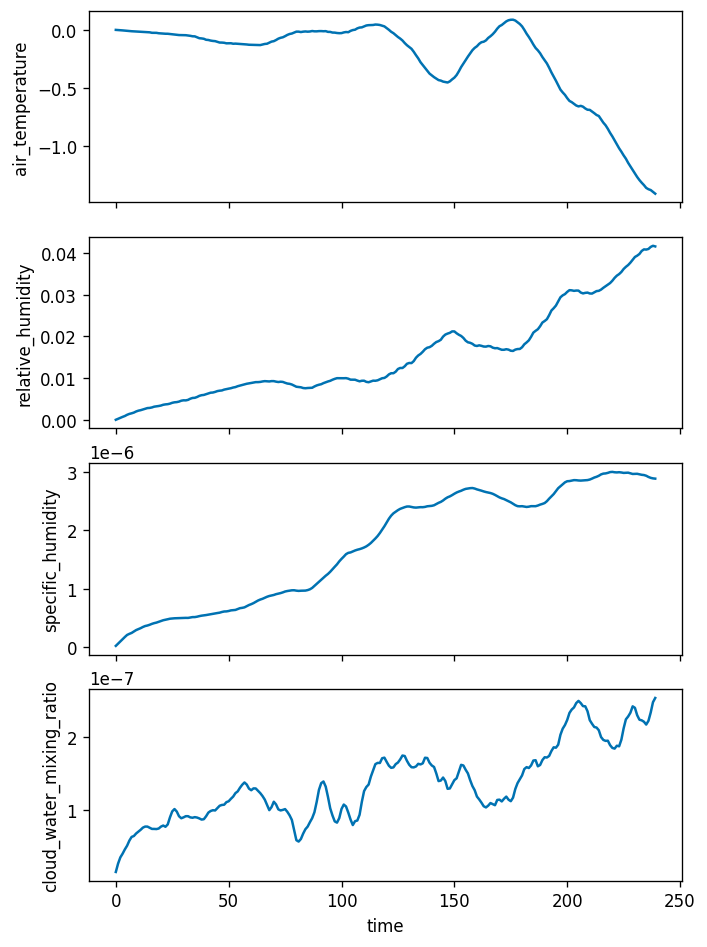

In [11]:
nrows = len(use_vars)
fig, ax = plt.subplots(nrows, 1, figsize=(6, 2*nrows), dpi=120, sharex=True)
for i, (field, ds) in enumerate(arctic_data_bias.items()):
    ds[field].mean(dim=["init", "z", "lat"]).plot(ax=ax[i])
    if i < nrows - 1:
        ax[i].set_xlabel("")
plt.tight_layout(h_pad=0.1)
plt.show()

In [12]:
# get a sense for noise floor of precpd

# getting precpd use total zc - gscond zc tendency for specific humidity
# gscond zc has smaller values removed via classifier
# look again at the arctic region since that's the largest mean bias 
# check time 0 physics vs emulator
# check time 4 (1/2 day), 8 (1day), 232 (29 day)
# plot a histogram for each

# start with a single month then scale up to all 12

# plot tendency bias in kg/kg/day for the region
# some scatter plot of amount of precip produced against evaporation?

In [9]:
online_data = xr.concat([
    run_data[1].drop_vars("time") for run_data in opened_run_data.values()
], dim="init")

In [10]:
total_key = "tendency_of_{}_due_to_zhao_carr_{}"
gscond_key = "tendency_of_{}_due_to_gscond_{}"


def get_all_tends(data, source, varkey="specific_humidity"):
    gkey = gscond_key.format(varkey, source)
    tkey = total_key.format(varkey, source)
    gscond = select_polar_stratosphere(data[gkey], True)
    total = select_polar_stratosphere(data[tkey], True)
    precpd = total - gscond
    return gscond, precpd, total

emu_gs, emu_pr, emu_tot = get_all_tends(online_data, "emulator")
phy_gs, phy_pr, phy_tot = get_all_tends(online_data, "physics")
emu_cl_gs, emu_cl_pr, _ = get_all_tends(online_data, "emulator", varkey="cloud_water")
phy_cl_gs, phy_cl_pr, _ = get_all_tends(online_data, "physics", varkey="cloud_water")


In [13]:

phy_t_gs, phy_t_pr, _ = get_all_tends(online_data, "physics", varkey="air_temperature")
emu_t_gs, emu_t_pr, _ = get_all_tends(online_data, "emulator", varkey="air_temperature")


In [14]:
arctic_tendencies = {
    "gscond_physics_dq": phy_gs,
    "gscond_emulator_dq": emu_gs,
    "gscond_physics_dc": phy_cl_gs,
    "gscond_emulator_dc": emu_cl_gs,
    "precpd_physics_dq": phy_pr,
    "precpd_emulator_dq": emu_pr,
    "precpd_physics_dc": phy_cl_pr,
    "precpd_emulator_dc": emu_cl_pr,
    "precpd_emulator_dt": emu_t_pr,
    "precpd_physics_dt": phy_t_pr,
}

@common.memoize_xarray_out
def load_polar_strat_tends_at_timerange(key, slice_args):
    return arctic_tendencies[key].isel(time=slice(*slice_args)).to_dataset(name=key).load()


In [14]:
def plot_hist_compare(key1, key2, time_ranges=((32,), (125, 175), (-50, None))):
    bins = np.logspace(-20, -8, 50)
    for trange in time_ranges:
        data1 = load_polar_strat_tends_at_timerange(key1, trange)[key1]
        data2 = load_polar_strat_tends_at_timerange(key2, trange)[key2]

        plt.figure(dpi=120)
        plt.hist(
            abs(data1.values.flatten()),
            bins=bins,
            log=True,
            histtype="step",
            label=key1
        )
        plt.hist(
            abs(data2.values.flatten()),
            bins=bins,
            log=True,
            histtype="step",
            label=key2
        )
        plt.gca().set_xscale("log")
        plt.legend()
        plt.show()

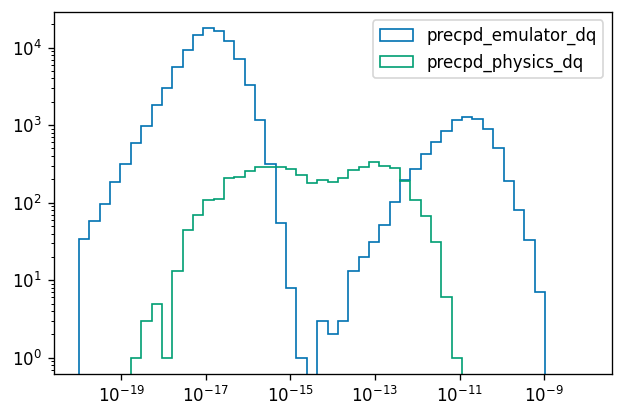

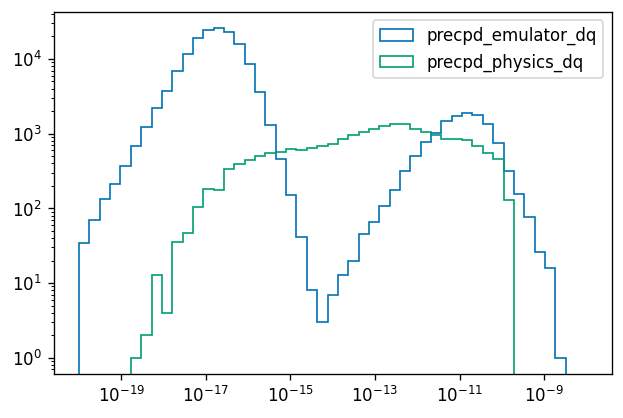

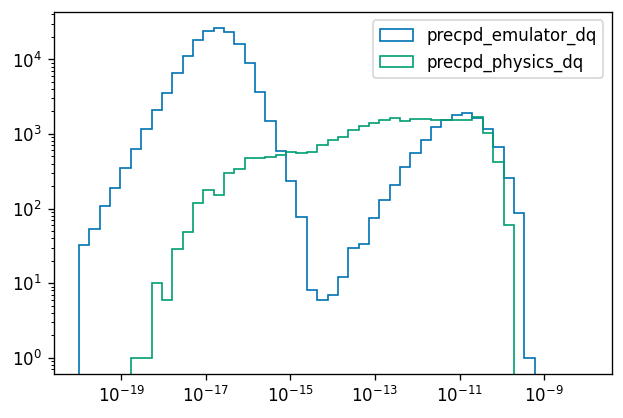

In [15]:
plot_hist_compare("precpd_emulator_dq", "precpd_physics_dq")

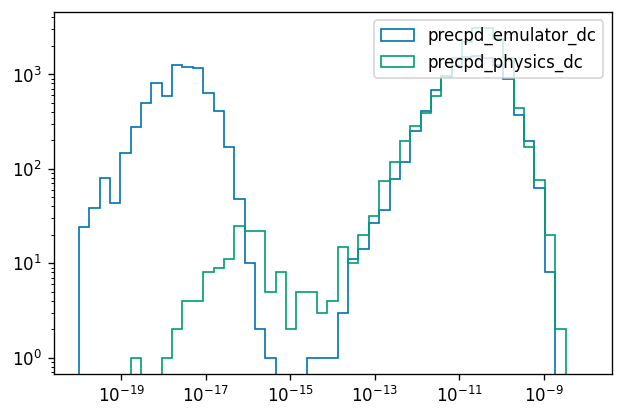

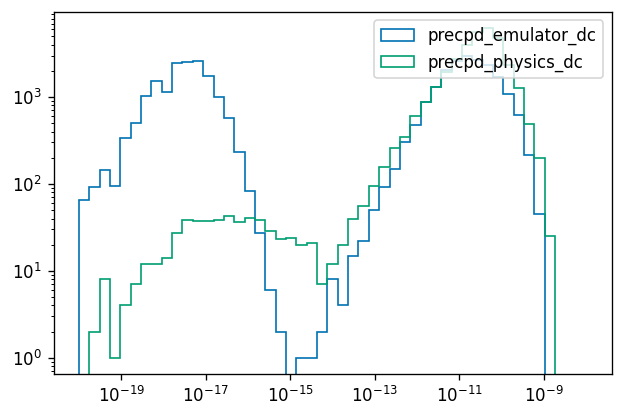

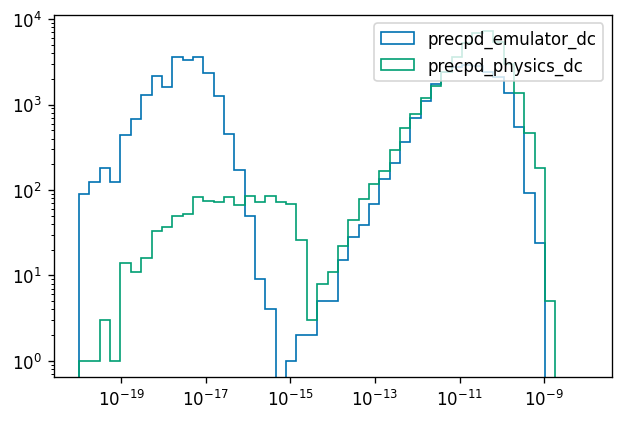

In [16]:
plot_hist_compare("precpd_emulator_dc", "precpd_physics_dc")

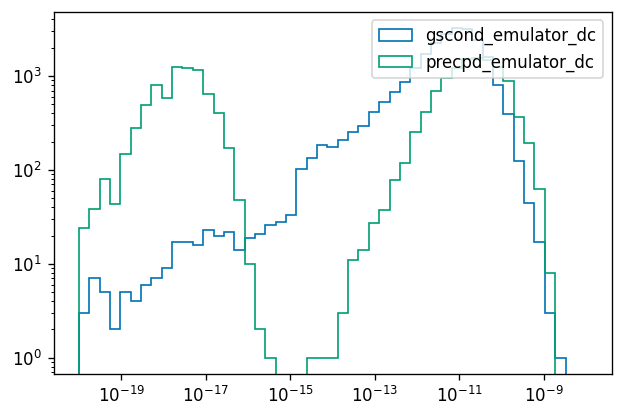

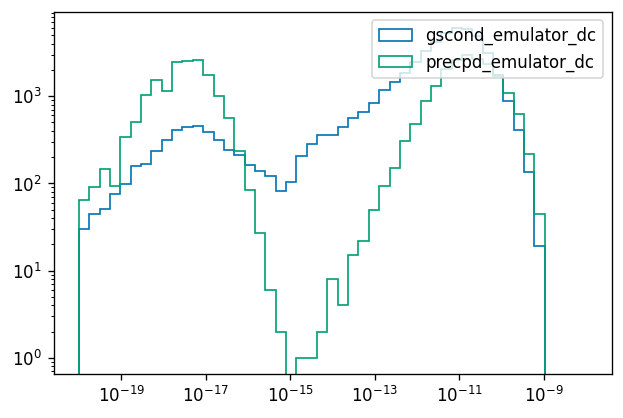

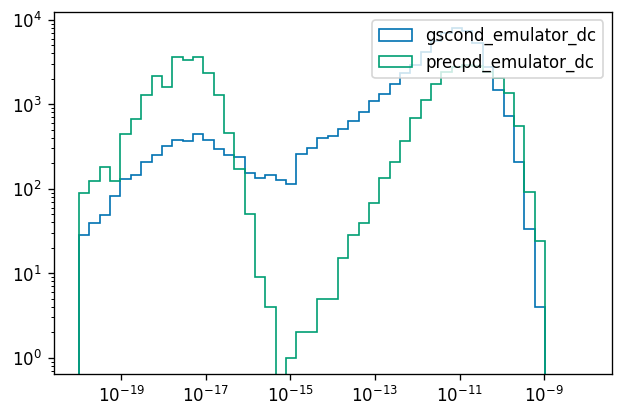

In [17]:
plot_hist_compare("gscond_emulator_dc", "precpd_emulator_dc")

In [11]:
def get_flat_above_thresh(data, threshold=1e-15):
    data = data.where(abs(data) > threshold).values.flatten()
    mask = np.isfinite(data)
    return data[mask]


In [12]:
bins = np.logspace(-15, -9, 50)

In [17]:
def _get_day(tidx, stop_arg=False, num_times=240):
    if tidx is None:
        if stop_arg:
            return num_times / 8.0
        else:
            return 0
    elif tidx < 0:
        return (num_times + tidx) / 8.0
    else:
        return tidx / 8.0

def get_day_str_from_trange(trange):
    if len(trange) == 1:
        return f"days 0-{_get_day(trange[0], stop_arg=True):1.1f}"
    else:
        return f"days {_get_day(trange[0], stop_arg=False):1.1f}-{_get_day(trange[1], stop_arg=True):1.1f}"


def get_key(subroutine, source, varname):
    return f"{subroutine}_{source}_{varname}"


def plot_symlog_hist_compare(subroutine="gscond", time_ranges=((32,), (64, 96), (125, 175), (-50, None))):
    bins = np.logspace(-20, -8, 50)
    full_bins = np.concatenate([-bins[::-1], bins])

    keys = [get_key(*args) for args in product([subroutine], ["emulator", "physics"], ["dq", "dc"])]
    for trange in time_ranges:
        plt.figure(dpi=120)
        
        bins = np.logspace(-15, -9, 50)
        for key in keys:
            if subroutine == "gscond" and "dq" in key:
                continue
            
            data = load_polar_strat_tends_at_timerange(key, trange)[key]
            flat = get_flat_above_thresh(data)

            if "physics" in key:
                lstyle = "--"
            else:
                lstyle = "-"

            plt.hist(flat, bins=full_bins, histtype="step", label=key, log=True, linestyle=lstyle)
        plt.xscale("symlog", linthreshx=1e-15)
        plt.legend(loc="upper center")
        plt.title(f"{subroutine} tendency histogram:  {get_day_str_from_trange(trange)}")
        plt.show()


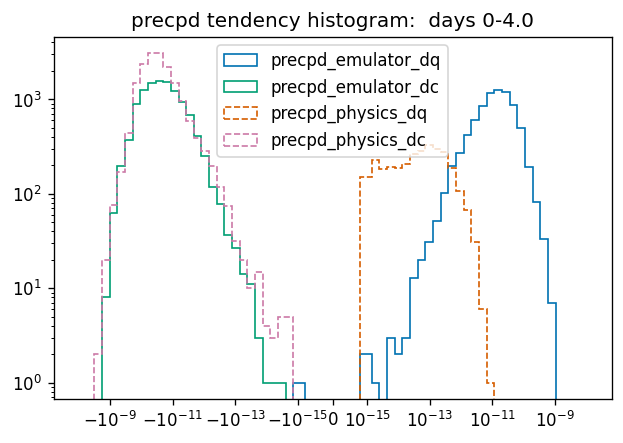

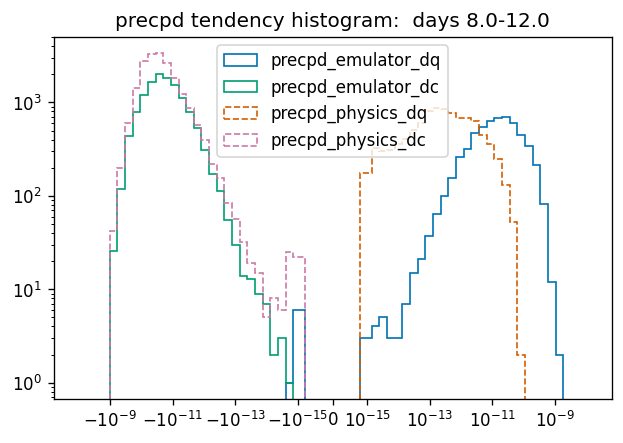

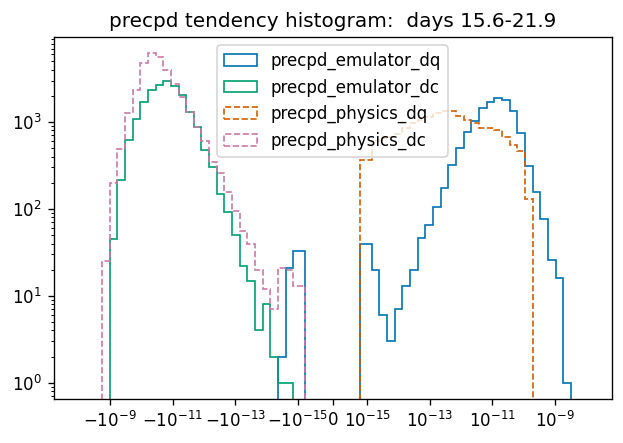

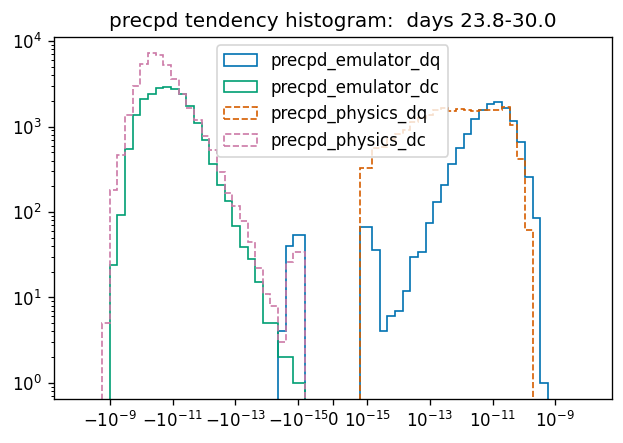

In [45]:
plot_symlog_hist_compare(subroutine="precpd")

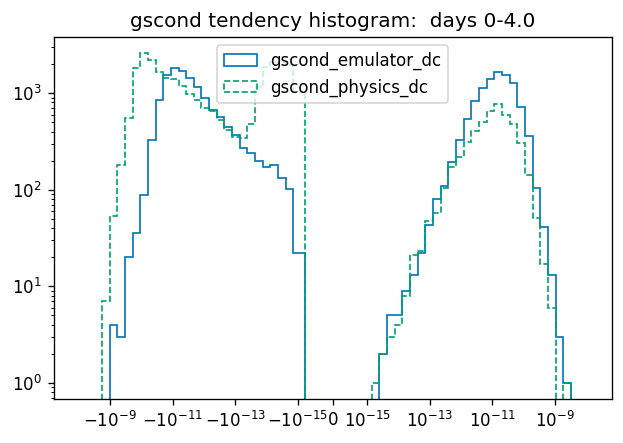

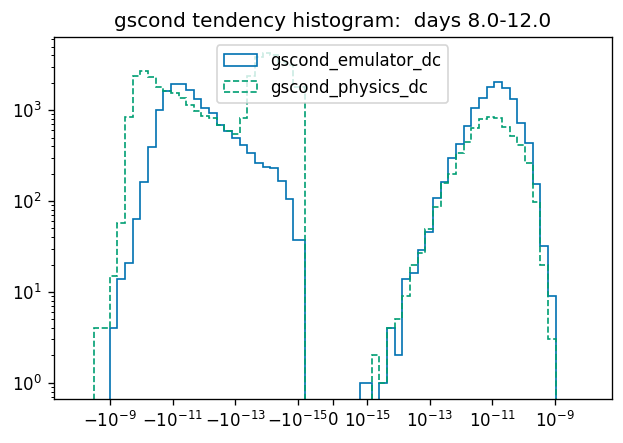

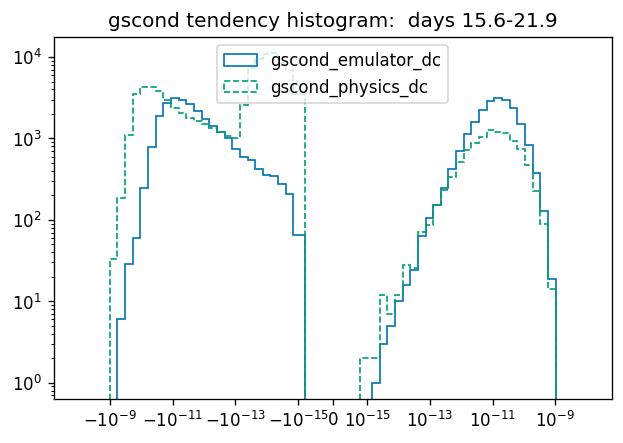

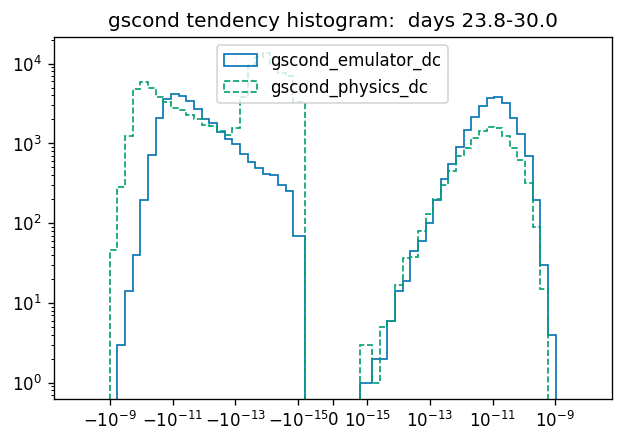

In [46]:
plot_symlog_hist_compare(subroutine="gscond")

## Check absolute tendency bias during time frames

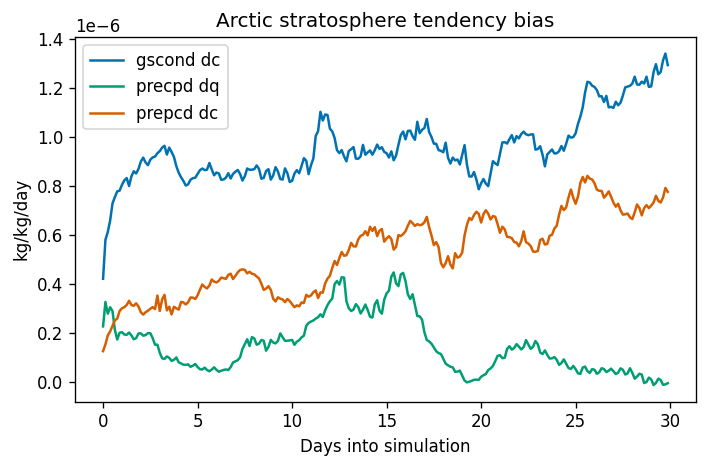

In [11]:
#slow 
@common.memoize_xarray_out
def get_arctic_tendency_bias(subroutine, varkey):
    emu_key = get_key(subroutine, "emulator", varkey)
    phy_key = get_key(subroutine, "physics", varkey)

    emu = arctic_tendencies[emu_key]
    phy = arctic_tendencies[phy_key]
    return (emu - phy).mean(dim=["init", "lat", "z"]).to_dataset(name="bias").load()


gscond_cl_bias = get_arctic_tendency_bias("gscond", "dc")["bias"] * (60**2 * 24) # kg/kg/day
precpd_q_bias = get_arctic_tendency_bias("precpd", "dq")["bias"] * (60**2 * 24) # kg/kg/day
precpd_cl_bias = get_arctic_tendency_bias("precpd", "dc")["bias"] * (60**2 * 24) # kg/kg/day

plt.figure(dpi=120)
gscond_cl_bias.plot(label="gscond dc")
precpd_q_bias.plot(label="precpd dq")
precpd_cl_bias.plot(label="prepcd dc")
plt.title("Arctic stratosphere tendency bias")
plt.ylabel("kg/kg/day")
plt.xticks(ticks=np.arange(241, step=40), labels=[f"{int(i/8):1d}" for i in np.arange(241, step=40)])
plt.xlabel("Days into simulation")
plt.legend()
plt.tight_layout()
plt.show()

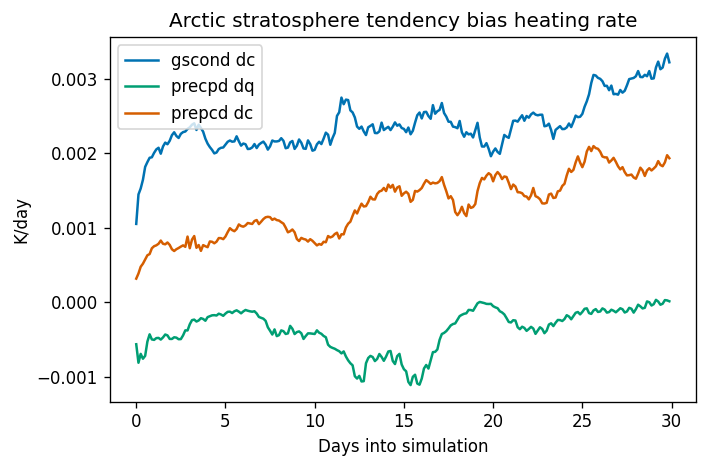

In [14]:
cp = 1004.6 # J/kg/K
g = 9.81 # m/s^2
Lv = 2.5e6 # J/kg

# convert kg/kg/day to K/day
def convert_to_K_day(da):
    return da * Lv / cp

plt.figure(dpi=120)
convert_to_K_day(gscond_cl_bias).plot(label="gscond dc")
(-1 * convert_to_K_day(precpd_q_bias)).plot(label="precpd dq")
convert_to_K_day(precpd_cl_bias).plot(label="prepcd dc")
plt.title("Arctic stratosphere tendency bias heating rate")
plt.ylabel("K/day")
plt.xticks(ticks=np.arange(241, step=40), labels=[f"{int(i/8):1d}" for i in np.arange(241, step=40)])
plt.xlabel("Days into simulation")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
.003 * 30

0.09

Gscond cloud bias [days 0-4.0] = 8.36e-07 kg/kg/day
Precpd vapor bias [days 0-4.0] = 1.82e-07 kg/kg/day
Precpd cloud bias [days 0-4.0] = 2.84e-07 kg/kg/day
Gscond cloud bias [days 8.0-12.0] = 8.98e-07 kg/kg/day
Precpd vapor bias [days 8.0-12.0] = 1.98e-07 kg/kg/day
Precpd cloud bias [days 8.0-12.0] = 3.60e-07 kg/kg/day
Gscond cloud bias [days 15.6-21.9] = 9.40e-07 kg/kg/day
Precpd vapor bias [days 15.6-21.9] = 1.39e-07 kg/kg/day
Precpd cloud bias [days 15.6-21.9] = 6.07e-07 kg/kg/day
Gscond cloud bias [days 23.8-30.0] = 1.15e-06 kg/kg/day
Precpd vapor bias [days 23.8-30.0] = 4.09e-08 kg/kg/day
Precpd cloud bias [days 23.8-30.0] = 7.37e-07 kg/kg/day


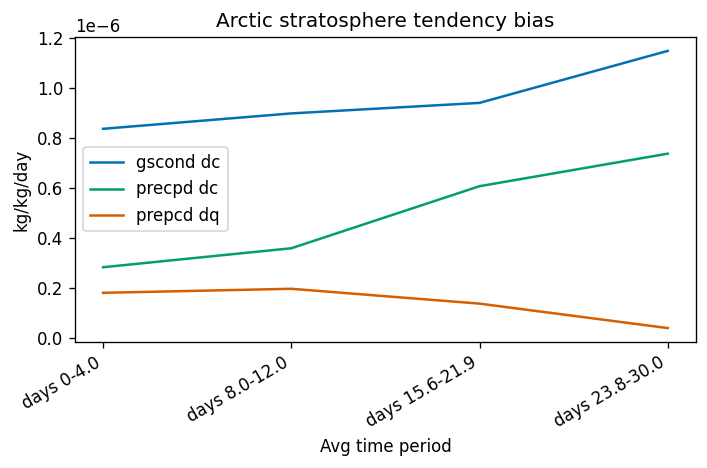

In [102]:
def get_arctic_bias(subroutine, varkey, trange):
    emu_key = get_key(subroutine, "emulator", varkey)
    phy_key = get_key(subroutine, "physics", varkey)
    emu = load_polar_strat_tends_at_timerange(emu_key, trange)[emu_key]
    phy = load_polar_strat_tends_at_timerange(phy_key, trange)[phy_key]
    return ((emu - phy).mean() * 60 * 60 * 24)

time_ranges = ((32,), (64, 96), (125, 175), (-50, None))
xlabels = [get_day_str_from_trange(trange) for trange in time_ranges]
xlocs = np.arange(4)*4
gscond_c_biases = []
precpd_c_biases = []
precpd_q_biases = []
for trange in time_ranges:
    gscond_cl_bias = get_arctic_bias("gscond", "dc", trange)
    gscond_c_biases.append(gscond_cl_bias)
    precpd_q_bias = get_arctic_bias("precpd", "dq", trange)
    precpd_q_biases.append(precpd_q_bias)
    precpd_cl_bias = get_arctic_bias("precpd", "dc", trange)
    precpd_c_biases.append(precpd_cl_bias)
    print(f"Gscond cloud bias [{get_day_str_from_trange(trange)}] = {gscond_cl_bias.values:1.2e} kg/kg/day")
    print(f"Precpd vapor bias [{get_day_str_from_trange(trange)}] = {precpd_q_bias.values:1.2e} kg/kg/day")
    print(f"Precpd cloud bias [{get_day_str_from_trange(trange)}] = {precpd_cl_bias.values:1.2e} kg/kg/day")

plt.figure(dpi=120)
plt.plot(xlocs, gscond_c_biases, label="gscond dc")
plt.plot(xlocs, precpd_c_biases, label="precpd dc")
plt.plot(xlocs, precpd_q_biases, label="prepcd dq")
plt.title("Arctic stratosphere tendency bias")
plt.ylabel("kg/kg/day")
plt.xlabel("Avg time period")
plt.xticks(ticks=xlocs, labels=xlabels, rotation=30, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
def plot_hexbin_precip_vs_dq(source, trange):
    precpd_dc = load_polar_strat_tends_at_timerange(get_key("precpd", source, "dc"), trange)[get_key("precpd", source, "dc")]
    precpd_dq = load_polar_strat_tends_at_timerange(get_key("precpd", source, "dq"), trange)[get_key("precpd", source, "dq")]
    tot_pr = -1 * precpd_dc.cumsum(dim="z")

    mask = np.logical_and(precpd_dq > 0, tot_pr > 0)
    tmp_q = precpd_dq.where(mask).values.flatten()
    tmp_pr = tot_pr.where(mask).values.flatten()
    tmp_pr = tmp_pr[np.isfinite(tmp_pr)]
    tmp_q = tmp_q[np.isfinite(tmp_q)]

    plt.figure(dpi=120)
    plt.hexbin(tmp_pr, tmp_q, xscale="log", yscale="log", bins="log")
    plt.colorbar()
    plt.title(f"Precpd {source} v-integ. precip vs. dq: {get_day_str_from_trange(trange)}")


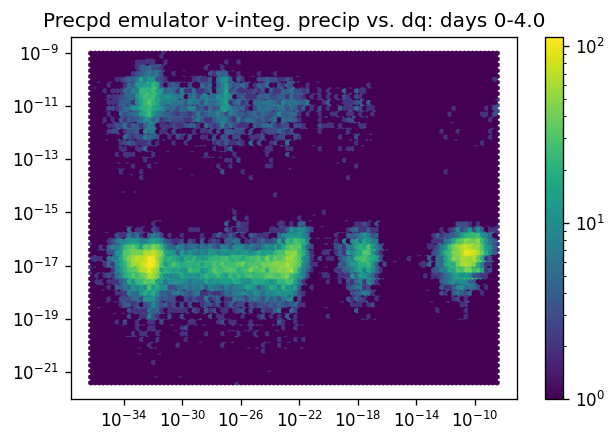

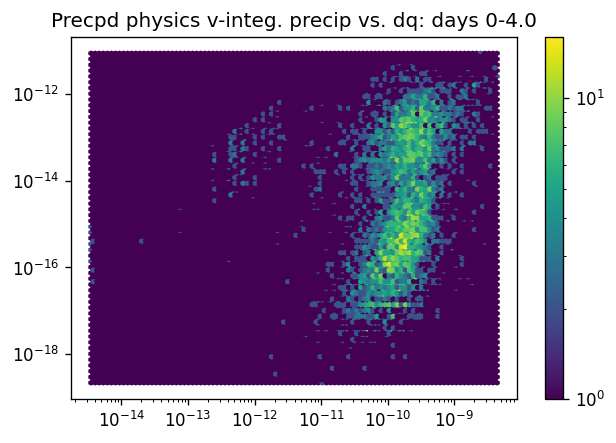

In [88]:
plot_hexbin_precip_vs_dq("emulator", (32,))
plt.show()
plot_hexbin_precip_vs_dq("physics", (32,))
plt.show()

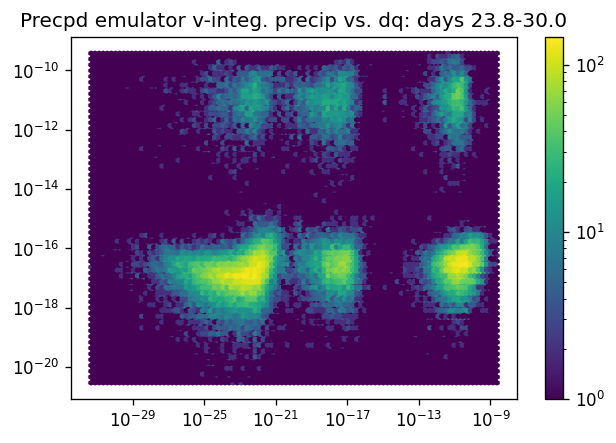

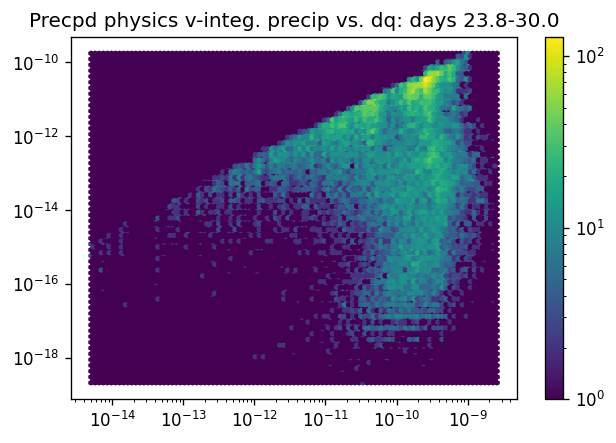

In [89]:
plot_hexbin_precip_vs_dq("emulator", (-50, None))
plt.show()
plot_hexbin_precip_vs_dq("physics", (-50, None))
plt.show()

In [21]:
def plot_hexbin_precip_vs_dt(source, trange):
    precpd_dc = load_polar_strat_tends_at_timerange(get_key("precpd", source, "dc"), trange)[get_key("precpd", source, "dc")]
    precpd_dt = load_polar_strat_tends_at_timerange(get_key("precpd", source, "dt"), trange)[get_key("precpd", source, "dt")]
    tot_pr = -1 * precpd_dc.cumsum(dim="z")

    mask = np.logical_and(precpd_dt < 0, tot_pr > 0)
    tmp_t = precpd_dt.where(mask).values.flatten()
    tmp_pr = tot_pr.where(mask).values.flatten()
    tmp_pr = tmp_pr[np.isfinite(tmp_pr)]
    tmp_t = tmp_t[np.isfinite(tmp_t)]

    plt.figure(dpi=120)
    plt.hexbin(tmp_pr, abs(tmp_t), xscale="log", yscale="log", bins="log")
    plt.colorbar()
    plt.title(f"Precpd {source} v-integ. precip vs. dt: {get_day_str_from_trange(trange)}")

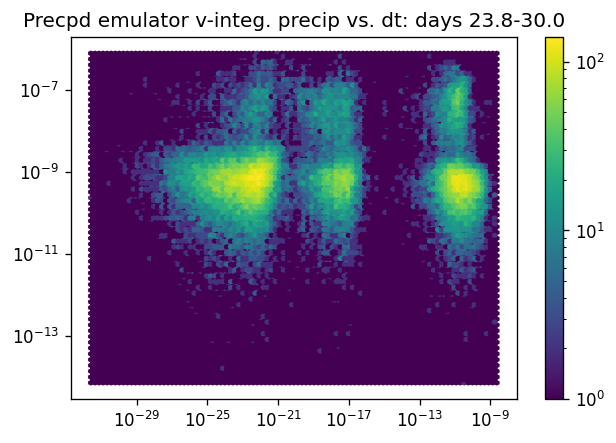

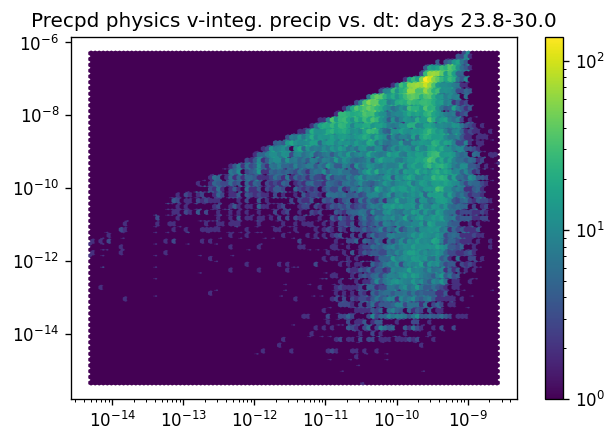

In [22]:
plot_hexbin_precip_vs_dt("emulator", (-50, None))
plt.show()
plot_hexbin_precip_vs_dt("physics", (-50, None))
plt.show()